# CTAP in a TQD with 1 HH

In this code we study the application of CTAP to to system of a linear TQD populated with one heavy-hole. In this code it's all the necesary lines to perform CTAP.

The Hamiltonian of the system is wirtten as

$$H=\left(\begin{array}{cccccc}
\uparrow, 0,0\rangle & |\downarrow, 0,0\rangle & |0, \uparrow, 0\rangle & |0, \downarrow, 0\rangle & |0,0, \uparrow\rangle & |0,0, \downarrow\rangle \\
\varepsilon_{1}+E_{Z} / 2 & 0 & -\tau_{12} & -i t_{F, 12} & 0 & 0 \\
0 & \varepsilon_{1}-E_{Z} / 2 & -i t_{F, 12} & -\tau_{12} & 0 & 0 \\
-\tau_{12} & i t_{F, 12} & \varepsilon_{2}+E_{Z} / 2 & 0 & -\tau_{23} & i t_{F, 23} \\
i t_{F, 12} & -\tau_{12} & 0 & \varepsilon_{2}-E_{Z} / 2 & i t_{F, 23} & -\tau_{23} \\
0 & 0 & -\tau_{23} & -i t_{F, 23} & \varepsilon_{3}+E_{Z} / 2 & 0 \\
0 & 0 & -i t_{F, 23} & -\tau_{23} & 0 & \varepsilon_{3}-E_{Z} / 2
\end{array}\right)
$$

The parameters $\varepsilon_i$ repesent the detunnings of the different quantum dos (QD), $E_Z=g^*\mu_BB_Z$ is the Zeeman splitting and $\tau_{ij}$ ($t_{F,ij}$) is the spin-conserving (spin-flip) tunnelling between dots $i$ and $j$. When the the condition $t_F\propto \tau$ is fullfilled we can find that there exists a dark state that populate the two edges of the array, with the same spin, and with no weight in the middle state:

$$
|\phi_{1,\text{DS}}\rangle =-\sin\theta|\uparrow,0,0\rangle+\cos\theta|0,0,\uparrow\rangle
$$

where we have defined the parameter $\tan\theta\equiv \tau_{23}/\tau_{12}$. Our goal is to transfer a hole from one end to the other one with the minimum population of the middle QD.

Magic lines for reloading my custum funtions each time a cell is executed. This allows me to make changed in these functions without need of restarting the kernel to apply them in this notebook. The figure of matplotlib are set to be interative.

In [1]:
%load_ext autoreload
%autoreload 1
%aimport general_functions, plotting_functions, hamiltonians
%matplotlib notebook

Import all the necessary functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hamiltonians import hamiltonian_3QD_1HH
from general_functions import solve_system
from plotting_functions import modify_plot, save_figure, zoomed_plot, cycle_color
from scipy.constants import h, e
from scipy.misc import derivative
import qutip as qt
import time as timer

styles=['science']
prefix='./stylelib/'
sufix='.mplstyle'

for i in range(len(styles)):
    styles[i]=prefix+styles[i]+sufix

plt.style.use('default')

Here we define all the constants of the system

In [50]:
hbar=((h / e) / (2 * np.pi)) * 10 ** 6 * 10 ** 9
ET = 0  # Zeeman splitting (ueV)
tau0 = 1.3  # Value for the tunelling parameter
tf = 10  #  Final time 

#Detunnings for the dots
e1=0
e2=0
e3=0

# Parameters of the detunnings for CTAP. THe definitions are shown in the next cell
tau = tf / 6  # Be careful, this is the parameter for the Gaussian shape tunnelling, not the tunnelling itself
sigma = tau

time = np.linspace(0, tf, 10**4,endpoint=True)  # Time vector in which compute the solution of the population

In the next cell there is all the pulses definition to perform CTAP without SOC. The Hamiltonian is written as

$$
\tilde{H}=\tilde{\tau}_{12}c_1^\dagger c_2+\tilde{\tau}_{23}c_2^\dagger c_3 + h.c.
$$

The inital Gaussian shape pulses are

$$
\begin{split}
\tau_{12}&=\tau_0\exp\left[-\frac{(t-t_f/2-\tau)^2}{\sigma^2}\right]\\
\tau_{23}&=\tau_0\exp\left[-\frac{(t-t_f/2+\tau)^2}{\sigma^2}\right]
\end{split}
$$

We define the following quantities

$$
\begin{split}
\tau_a&\equiv \dot{\theta}\\
\varphi&\equiv \arctan(\tau_a/\tau_{12})
\end{split}
$$

Using this we have teh modificed pulses

$$
\begin{split}
\tilde{\tau}_{12}&=\sqrt{\tau_{12}^2+\tau_a^2}\\
\tilde{\tau}_{23}&=\tau_{23}-\dot{\varphi}
\end{split}
$$

In [51]:
dv_stet=1e-5  # Step for the derivatives

# Gaussian shape pulses
tau12 = lambda t: tau0 * np.exp(-(t - tf / 2 - tau) ** 2 / sigma ** 2)
tau23 = lambda t: tau0 * np.exp(-(t - tf / 2 + tau) ** 2 / sigma ** 2)


# Auxiliar parameters
theta = lambda t: np.arctan(tau12(t) / tau23(t))
taua = lambda t: derivative(theta, t, dx=dv_stet)
phi = lambda t: np.arctan(taua(t) / tau12(t))


# Modified parameters
tau12_tilda = lambda t: np.sqrt(tau12(t) ** 2 + taua(t) ** 2)
tau23_tilda = lambda t: tau23(t) - derivative(phi, t, dx=dv_stet)

For the STA protocol, so we need to give a state that we will use to obtain the transference

$$
|\Psi(t)\rangle =\cos\chi\cos\eta|\uparrow,0,0\rangle -i\sin\eta|0,\uparrow,0\rangle -\sin\chi\cos\eta|0,0,\uparrow\rangle
$$

To simplify the expression we will solve the Schrödinger equation without SOC, obtaining the equations

$$
\begin{split}
\dot{\chi}&=\tan\eta(\tau_{12}\sin\chi+\tau_{23}\cos\chi)\\
\dot{\eta}&=\tau_{12}\cos\chi-\tau_{23}\sin\chi
\end{split}
$$

And the boundary constions are $\chi(0)=\eta(0)=\eta(t_f)=0$ and $\chi(t_f)=\pi/2$. Imposing the pulses to be smooth we have also boundary conditions of the derivatives of these parameres $\dot{\chi}(0)=\dot{\chi}(t_f)=\ddot{\chi}(0)=\ddot{\chi}(t_f)=0$ and $\dot{\eta}(0)=\dot{\eta}(t_f)=0$. One possible ansatz is

$$
\begin{split}
\chi&=\frac{\pi t}{2t_f}-\frac{1}{3}\sin(\frac{2\pi t}{t_f})+\frac{1}{24}\sin(\frac{4\pi t}{t_f})\\
\eta&=\arctan(\dot{\chi}/\alpha_0)
\end{split}
$$

Through the parameter $\alpha_0$ we have control in the maximum amplitude of the pulses, the larger this parameter is, the larger are the pulses.  It can be easily proven than the maximum population of the middle QD is at $t=t_f$, corresponding to the value

$$
P_{2,\max}=\frac{16\pi^2}{16\pi^2+9t_f^2\alpha_0^2}
$$

As we can expect, aumenting the total time of the transference is more adiabatic, and the middle dot is less populated during the protocol.

Solving the equation system, what is easily done by mathematica or by hand, we obtain that the modified pulses are

$$
\begin{split}
\tilde{\tau}_{12}&=\dot{\eta}\cos\chi+\dot{\chi}\frac{\sin\chi}{\tan\eta}\\
\tilde{\tau}_{23}&=-\dot{\eta}\sin\chi+\dot{\chi}\frac{\cos\chi}{\tan\eta}
\end{split}
$$

For the spin-flip tunnelling we estimate (with no proof) $t_F=a\tau $ with $a=0.4$

In [52]:
dx_derivative=1e-3  # Step for the derivatives
alpha0 = 5  #Parameter that controls the amplitude of the pulses


# Auxiliar parameters
chi = lambda t: np.pi * t / (2 * tf) - 1 / 3 * np.sin(2 * np.pi * t / tf) + 1 / 24 * np.sin(4 * np.pi * t / tf)
eta = lambda t: np.arctan(derivative(chi, t, dx=dx_derivative) / alpha0)

# Modified pulses
tau12_tilde_STA = lambda t: (derivative(eta, t, dx=dx_derivative) * np.cos(chi(t))+ 
                             derivative(chi, t, dx=dx_derivative) / (np.tan(eta(t))+1e-16) * np.sin(chi(t)))/np.sqrt(2)*hbar
tau23_tilde_STA = lambda t: (derivative(chi, t, dx=dx_derivative) * np.cos(chi(t)) / (np.tan(eta(t))+1e-16) - 
                             derivative(eta, t, dx=dx_derivative) * np.sin(chi(t)))/np.sqrt(2)*hbar

In the next cell we plot the pulses in which we are interested (CTAP or STA) and modify the plot if wanted for saving the figure

<IPython.core.display.Javascript object>


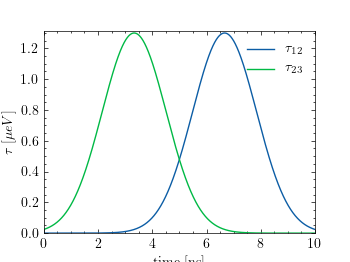

In [53]:
# Pulses to plot
pulse1=tau12
pulse2=tau23

save=False  # Parameter that control is the function must be saved

fig, ax= plt.subplots() # Initialize figure

#Plot pulses
ax.plot(time, pulse1(time), label=r'$\tau_{12}$')
ax.plot(time, pulse2(time), label=r'$\tau_{23}$')

# Modify limits
ax.set_xlim([0, tf])
ax.set_ylim([0, np.max([pulse1(time), pulse2(time)]) * 1.01])

# Set labels and legend
ax.legend()
ax.set_xlabel('time [ns]')
ax.set_ylabel(r'$\tau\; [\mu eV]$')

#If the figure must be saved then it is modified and saved if the parameter overwrite is set to True
if save:
    modify_plot(ax,fig=fig,label_size=11, tick_label_size=9, lines_width=2, legend=True, legend_size=10,lines_bool=True,
                figsize=[5,3])
    save_figure(fig,'STA_TQD_Pulses', overwrite=False);

Now we must solve the system, what can be done using the density matrix an the EDO

$$
\frac{d\rho}{d t}=-\frac{i}{\hbar}[H,\rho]
$$

The system is initiate in the state $|\uparrow, 0,0\rangle$, that is only the first enty of the matrix is non-zero $\rho(0,0)=1$.

At all times the trace of the density matrix must be equals to the unity. Due to some numerial error in the solution of the dinamy of the system this is not exactly fulfilled. In the next figure we show the errors that deviate the trace to the unity

<IPython.core.display.Javascript object>


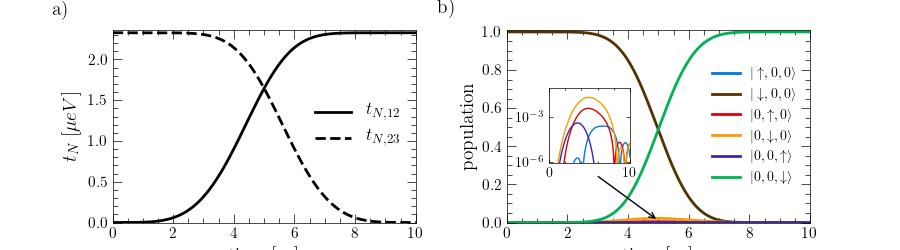

10.0%. Run time:   0.05s. Est. time left: 00:00:00:00
20.0%. Run time:   0.11s. Est. time left: 00:00:00:00
30.0%. Run time:   0.16s. Est. time left: 00:00:00:00
40.0%. Run time:   0.22s. Est. time left: 00:00:00:00
50.0%. Run time:   0.28s. Est. time left: 00:00:00:00
60.0%. Run time:   0.33s. Est. time left: 00:00:00:00
70.0%. Run time:   0.40s. Est. time left: 00:00:00:00
80.0%. Run time:   0.47s. Est. time left: 00:00:00:00
90.0%. Run time:   0.66s. Est. time left: 00:00:00:00
Total run time:   0.74s
The maximum population in the middle dot is: 0.026012906177569683
The maximum population out of the adiabatic states is: 0.026105107827683542
The error in the fidelity is: 4.234761959043265e-05
Figure saved


In [61]:
save=False
subplot=True

plt.style.use(styles)
pulse1=tau12_tilde_STA
pulse2=tau23_tilde_STA

cut=10

zoom=True

if subplot:
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(9,2.5))
    fig.subplots_adjust(wspace=0.3)
else:
    fig, ax = plt.subplots()
    axs=[0,ax]

if subplot:

    #Plot pulses
    axs[0].plot(time[:-cut], pulse1(time)[:-cut],'k-', label=r'$t_{N,12}$')
    axs[0].plot(time[cut:], pulse2(time)[cut:], 'k--',label=r'$t_{N,23}$')
    
    axs[0].legend()
    
    # Modify limits
    axs[0].set_xlim([0, tf])
    axs[0].set_ylim([0, np.max([pulse1(time), pulse2(time)]) * 1.01])
    
    # Set labels and legend
    
    axs[0].set_xlabel('time [ns]')
    axs[0].set_ylabel(r'$t_N\; [\mu eV]$')
    axs[0].text(-2,2.54,'a)',{'fontsize':14})

phase=0
prop=0.4

tau12_interpolated=qt.Cubic_Spline(time[0],time[-1],pulse1(time))
tau23_interpolated=qt.Cubic_Spline(time[0],time[-1],pulse2(time))

H0=hamiltonian_3QD_1HH(*[e1,e2,e3, ET, 0, 0, 0, 0, 0])/hbar
H0=qt.Qobj(H0)
H1=hamiltonian_3QD_1HH(*[0, 0, 0, 0, 1, 0, prop, 0, phase])/hbar
H1=qt.Qobj(H1)
H2=hamiltonian_3QD_1HH(*[0, 0, 0, 0, 0, 1, 0, prop, phase])/hbar
H2=qt.Qobj(H2)

H=[H0,[H1,tau12_interpolated],[H2,tau23_interpolated]]

test=np.eye(6)*0
test=qt.Qobj(test)

psi0 = qt.basis(6, 1)

options = qt.Options(atol=1e-15,rtol=1e-13)

solution=qt.mesolve(H, psi0, time,progress_bar=True, c_ops=None, options=options)

states = np.zeros([6, len(time)], dtype=complex)

for j in range(0, len(time)):
    # prob = np.diag(solution.states[j].full())
    # phases = np.exp(1j * np.angle(solution.states[j].full())[0, :])
    # states[:, j] = np.sqrt(prob) * phases
    
    temp=solution.states[j].full()
    states[:, j] = temp[:,0]

    
prob=np.abs(states)**2
    
names = [r'$|\uparrow,0,0\rangle$', r'$|\downarrow,0,0\rangle$', r'$|0,\uparrow,0\rangle$', r'$|0,\downarrow,0\rangle$',
         r'$|0,0,\uparrow\rangle$', r'$|0,0,\downarrow\rangle$']  # List with all the labels for the legend shorted


limit_population=1e-6

styles_lines=['-','-','-','-','-','-']
colors_index=[0,5,1,2,4,3]
colors=cycle_color(colors_index)
counter=0
for i in range (0,6):
    if np.max(prob[i,:]) > limit_population:
        axs[1].plot(time,prob[i,:],styles_lines[i], label=names[i], c=colors[i])
        counter+=1

    
if zoom:
    # Plot a zoom for the states with less population than can not be seen in the main figure
    ax_zoom=zoomed_plot(fig,axs[1],[0.61,0.35],[0.09,0.3],[time,prob[0,:]],x_limit=[0,tf], y_limit=[0,0.004])
    limit_sup=1e-1
    for i in range (0,6):
        if np.max(prob[i,:]) < limit_sup and np.max(prob[i,:]) > limit_population:
            ax_zoom.plot(time,prob[i,:],styles_lines[i], c=colors[i])
    ax_zoom.ticklabel_format(axis='y',style='sci',scilimits=(0,0),useMathText=False)
    ax_zoom.set_yscale('log')
    ax_zoom.set_ylim([1e-6,1e-1])
    axs[1].annotate("", xy=(tf/2,0.01), xytext=(tf/3.4,0.25),arrowprops=dict(arrowstyle="->"))
    
axs[1].set_xlim([time[0],time[-1]])
axs[1].set_ylim([0,1.01])

axs[1].set_xlabel('time [ns]')
axs[1].set_ylabel('population')

axs[1].legend(loc=7)

if subplot:
    axs[1].text(-2.3,1.1,'b)',{'fontsize':14})

prob1=prob

#Print some interesting data of the populations

print('The maximum population in the middle dot is: {}'.
      format(np.max(prob[2,:]+prob[3,:]))) # |0,↑,0> + |0,↓,0>
print('The maximum population out of the adiabatic states is: {}'.
      format(np.max(prob[0,:]+prob[2,:]+prob[3,:]+prob[4,:])))  # |↓,0,0>+ |0,↑,0> + |0,↓,0>+|0,0,↓>
print('The error in the fidelity is: {}'.format(1-prob[5,-1])) #1-|0,0,↑>(tf)

if save:
    if subplot:
        modify_plot(axs[0],label_size=14, tick_label_size=11, lines_width=2, legend=True, legend_size=13,
                    lines_bool=True, colors_bool=False)
    
    modify_plot(axs[1],label_size=14, tick_label_size=11, lines_width=2, legend=True, legend_size=13,
                lines_bool=True, colors_bool=False, styles=False)
    
    axs[1].legend(loc=7)

    save_figure(fig,'STA_TQD_Results_2', overwrite=save, dic='thesis', extension='pdf');

In [62]:
np.max(prob[0,:])

0.0002667969975953494

In [60]:
print(16*np.pi**2/(16*np.pi**2+(3*alpha0*tf)**2))

0.006969470919275528


<IPython.core.display.Javascript object>


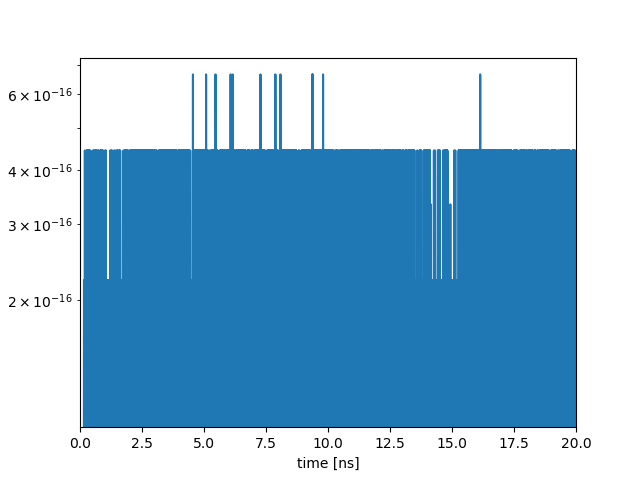

In [22]:
plt.figure() #Initialice figure
plt.plot(time,np.abs(1-np.sum(prob,axis=0))) #Plot |1-tr(ρ)| at the times in which we have solved the system

plt.yscale('log') # Set the y-axis in log scale

plt.xlabel('time [ns]')
plt.ylabel(r'$|1-tr(\rho)|$')

# Modify limits
plt.xlim([0, time[-1]]);

<IPython.core.display.Javascript object>


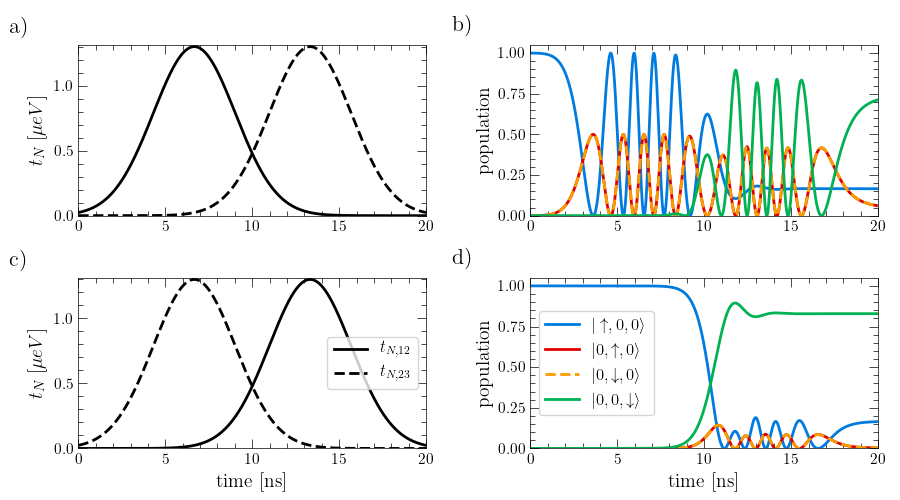

Figure saved


In [87]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(9,5))

pulse1=tau12
pulse2=tau23

save=False  # Parameter that control is the function must be saved


#Plot pulses
axs[0,0].plot(time, pulse2(time),'k-', label=r'$t_{N,12}$')
axs[0,0].plot(time, pulse1(time), 'k--',label=r'$t_{N,23}$')

# Modify limits
axs[0,0].set_xlim([0, tf])
axs[0,0].set_ylim([0, np.max([pulse1(time), pulse2(time)]) * 1.01])

# Set labels and legend

# axs[0,0].set_xlabel('time [ns]')
axs[0,0].set_ylabel(r'$t_N\; [\mu eV]$')

#Plot pulses
axs[1,0].plot(time, pulse1(time),'k-', label=r'$t_{N,12}$')
axs[1,0].plot(time, pulse2(time),'k--', label=r'$t_{N,23}$')


# Modify limits
axs[1,0].set_xlim([0, tf])
axs[1,0].set_ylim([0, np.max([pulse1(time), pulse2(time)]) * 1.01])

# Set labels and legend
axs[1,0].legend(loc=5)
axs[1,0].set_xlabel('time [ns]')
axs[1,0].set_ylabel(r'$t_{N}\; [\mu eV]$')

names = [r'$|\uparrow,0,0\rangle$', r'$|\downarrow,0,0\rangle$', r'$|0,\uparrow,0\rangle$', r'$|0,\downarrow,0\rangle$',
         r'$|0,0,\uparrow\rangle$', r'$|0,0,\downarrow\rangle$']  # List with all the labels for the legend shorted
limit_popu=1e-2

styles=['-','','-','--','','-']

for i in range (0,6):
    if np.max(prob1[i,:] > limit_popu):
        axs[0,1].plot(time,prob1[i,:],styles[i], label=names[i], c=colors[i])
    if np.max(prob2[i,:] > limit_popu):
        axs[1,1].plot(time,prob2[i,:],styles[i], label=names[i], c=colors[i])

axs[1,1].set_xlabel('time [ns]')
axs[1,1].set_ylabel('population')

#axs[0,1].set_xlabel('time [ns]')
axs[0,1].set_ylabel('population')

axs[1,1].set_xlim([0, tf])
axs[0,1].set_xlim([0, tf])

axs[1,1].set_ylim([0,1.05])
axs[0,1].set_ylim([0,1.05])

axs[1,1].legend()
    
axs[0,0].text(-4,1.4,'a)',{'fontsize':16})
axs[0,1].text(-4.5,1.13,'b)',{'fontsize':16})
axs[1,0].text(-4,1.4,'c)',{'fontsize':16})
axs[1,1].text(-4.5,1.13,'d)',{'fontsize':16})
    
plt.tight_layout()

fig.subplots_adjust(wspace=0.3)

#If the figure must be saved then it is modified and saved if the parameter overwrite is set to True
if save:
    modify_plot(axs[1,0],label_size=14, tick_label_size=11, lines_width=2, legend=True, legend_size=500,
                lines_bool=True, colors_bool=False)
    
    modify_plot(axs[1,1],label_size=14, tick_label_size=11, lines_width=2, legend=True, legend_size=13,
                lines_bool=True, colors_bool=False, styles=False)
    
    modify_plot(axs[0,0],label_size=14, tick_label_size=11, lines_width=2,lines_bool=True, colors_bool=False)
    modify_plot(axs[0,1],label_size=14, tick_label_size=11, lines_width=2,lines_bool=True, colors_bool=False,styles=False)
    
    axs[1,0].legend(fontsize=12,loc=7, frameon=True)
    axs[1,1].legend(fontsize=12,loc=6, frameon=True)
    
    save_figure(fig,'CTAP_TQD_Results', overwrite=save, dic='thesis', extension='pdf');